#Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing Libraries

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 


#Loading the image from the drive. (Taking a small image(128*128) as doubly toeplitz matrix takes a lot of space in memory)
For a 256x256 image it would take around 32 GigaByte space in memory for its doubly blocked toeplitz matrix


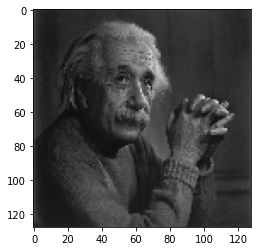

In [ ]:
path = '/content/drive/MyDrive/4_1/ImageLab/Lab1/ein.jpg'

img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (128,128))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#Declaring the kernel(Filter)

In [ ]:
kernel = np.array(([0,-1,0],
                   [-1,5,-1],
                   [0,-1,0]),
                  np.float32)

#Taking Row and Column Count of input image and kernel

In [ ]:
I_row_num, I_col_num = img.shape
F_row_num, F_col_num = kernel.shape


#Output Dimension
output_row = image_row + kernel_row - 1,
output_col = image_col + kernel_col - 1
(for full convolution)

In [ ]:
output_row_num = I_row_num + F_row_num - 1
output_col_num = I_col_num + F_col_num - 1
output_shape = output_row_num, output_col_num
print(output_row_num, output_col_num)

130 130


#Zero Padding the filter to make the size of the filter same as output

In [ ]:
F_zero_padded = np.pad(kernel, ((output_row_num-F_row_num, 0),
                                (0,output_col_num-F_col_num)),
                       'constant', constant_values = 0)
print(F_zero_padded)


[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0. -1.  0. ...  0.  0.  0.]
 [-1.  5. -1. ...  0.  0.  0.]
 [ 0. -1.  0. ...  0.  0.  0.]]


#The column of these generated toepliitz matrices should be same as the number of columns of the input of the input(img) 

In [ ]:
#importing additional library for toeplitz function
import scipy.linalg as sl
toeplitz_list = []
for i in range(F_zero_padded.shape[0]-1, -1,-1):#iterating from last row to first (as our image will be flipped upside down)
  c = F_zero_padded[i,:];#taking the i'th row 
  r = np.r_[c[0], np.zeros(I_col_num-1)] #concatening two array quickly (Translates slice objects to concatenation along the first axis)
  toeplitz_m = sl.toeplitz(c,r)#createing toeplitz matrices for each row
  toeplitz_list.append(toeplitz_m)
  
  

#Doubly Block Creation

In [ ]:
c = range(1, F_zero_padded.shape[0]+1)
r = np.r_[c[0], np.zeros(img.shape[0]-1, dtype=int)]#number of column in this symbolic doubly blocked toeplitz should be equal to the number of row in the input signal
doubly_indices = sl.toeplitz(c,r)
print(doubly_indices)

[[  1   0   0 ...   0   0   0]
 [  2   1   0 ...   0   0   0]
 [  3   2   1 ...   0   0   0]
 ...
 [128 127 126 ...   3   2   1]
 [129 128 127 ...   4   3   2]
 [130 129 128 ...   5   4   3]]


#Calculating the size of the doubly_blocked matrices from doubly indices and the size of toeplitz matrix for each row of zero_padded_kernel

In [ ]:
#shape of one of those small toeplitz matrices
h = toeplitz_list[0].shape[0]*doubly_indices.shape[0]
w = toeplitz_list[0].shape[1]*doubly_indices.shape[1]
doubly_blocked_shape = [h, w]
doubly_blocked = np.zeros(doubly_blocked_shape)


#Filling the doubly blocked indices with our toepelitz matrices' values

In [ ]:
#tile the toeplitz matrix
b_h, b_w = toeplitz_list[0].shape
for i in range(doubly_indices.shape[0]):
  for j in range(doubly_indices.shape[1]):
    start_i = i*b_h
    start_j = j*b_w
    end_i = start_i+b_h
    end_j = start_j + b_w
    doubly_blocked[start_i: end_i, start_j: end_j]=toeplitz_list[doubly_indices[i,j]-1]
print(doubly_blocked)
print(doubly_blocked.shape)

[[ 0.  0.  0. ...  0.  0.  0.]
 [-1.  0.  0. ...  0.  0.  0.]
 [ 0. -1.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 0.  0.  0. ...  0.  0. -1.]
 [ 0.  0.  0. ...  0.  0.  0.]]
(16900, 16384)


#Converting the input image to a vector of size img_height x img_width

In [ ]:
#input matrix to vector
def matrix_to_vector(input):
  input_h, input_w = input.shape
  output_vector = np.zeros(input_h*input_w, dtype=np.float32)
  #flip the input matrix upside down to start from the last row
  input = np.flipud(input)
  for i, row in enumerate(input):
    st = i*input_w
    nd = st+input_w
    output_vector[st:nd]=row
  return output_vector

# print(img)
# print(matrix_to_vector(img))

#Performing Convolution using only one matrix multiplication

In [ ]:
#get result of the convolution by matrix multiplication
vectorized_input = matrix_to_vector(img)
print(doubly_blocked.shape)
print(vectorized_input.shape)
print(vectorized_input)
result_vector = np.matmul(doubly_blocked, vectorized_input)
print("result: ", result_vector)

(16900, 16384)
(16384,)
[55. 41. 33. ... 51. 51. 63.]
result:  [  0. -55. -41. ... -51. -63.   0.]


#Converting the vector back to matrix of size output_shape to plt it as an image

In [ ]:
#vector_to_matrix
def vector_to_matrix(input, output_shape):
  output_h, output_w = output_shape
  output = np.zeros(output_shape, dtype=np.float32)
  for i in range(output_h):
    st = i*output_w
    nd = st+output_w
    output[i,:] = input[st:nd]
  #flipping again downup
  output = np.flipud(output)
  return output
out = vector_to_matrix(result_vector,  output_shape)

out = out/255


#Plotting the input image and output image after convolution

Input Image: 



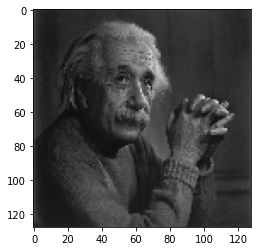

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output Image: 



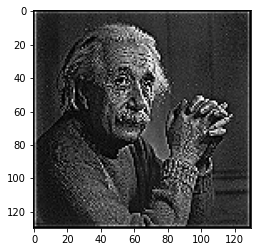

In [ ]:
print("Input Image: \n")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
print("Output Image: \n")
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
plt.show()

#Comparing the output with other built in function such as scipy.signal.convolve2d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'filter2D')

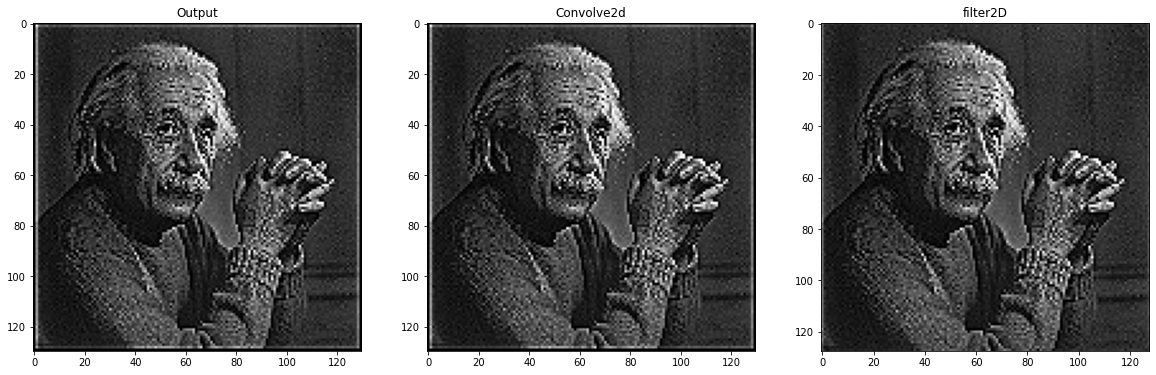

In [ ]:
from IPython.core.pylabtools import figsize


# Two subplots, unpack the axes array immediately
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,20))
ax1.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
ax1.set_title('Output')
from scipy import signal
result = signal.convolve2d(img, kernel, "full")/255
ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
ax2.set_title('Convolve2d')
result = cv2.filter2D(img, -1, kernel)
ax3.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
ax3.set_title('filter2D')

# print("Output Image: \n")
# plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
# plt.show()
# # print(out)
# from scipy import signal
# result = signal.convolve2d(img, kernel, "full")/255
# # print("\n\n",result)
# print("Using convolve2D: \n")
# plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
# plt.show()
# result = cv2.filter2D(img, -1, kernel)
# print(result)
# print(result.shape)
# plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
# plt.show()